# Import Libraries

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import TemporalData
import pathpyG as pp
import ast
import pickle
import numpy as np
import Temporal_Metrics as tm
import importlib
from pandas import Timestamp
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from datetime import datetime

# Load Cleaned

In [47]:
football = pd.read_pickle('Datasets\champions_league_Final.pkl')
football

,Date,Home Team,Away Team,Result,Stage,Scoresheet_Home,Scorer_Home,Scoresheet_Away,Scorer_Away,Year,Home Outcome
0,1992-11-25,Rangers,Marseille,2:2,Group A,"[79, 81]","[Gary McSwegan, Mark Hateley]","[31, 57]","[Alen Boksic, Rudi Völler]",1992,Draw
1,1992-11-25,Club Brugge,CSKA Moscow,1:0,Group A,[16],[Daniel Amokachi],[],[],1992,Win
2,1992-12-09,CSKA Moscow,Rangers,0:1,Group A,[],[],[13],[Ian Ferguson],1992,Loss
3,1992-12-09,Marseille,Club Brugge,3:0,Group A,"[4, 10, 25]","[Franck Sauzée, Alen Boksic, Alen Boksic]",[],[],1992,Win
4,1993-03-03,Club Brugge,Rangers,1:1,Group A,[44],[Tomasz Dziubinski],[72],[Pieter Huistra],1993,Draw
...,...,...,...,...,...,...,...,...,...,...,...
3707,2024-04-30,Bayern Munich,Real Madrid,2:2,Semi Finals Leg 1,"[53, 57]","[Leroy Sané, Harry Kane]","[24, 83]","[Vinicius Junior, Vinicius Junior]",2024,Draw
3708,2024-05-01,Bor. Dortmund,Paris SG,1:0,Semi Finals Leg 1,[36],[Niclas Füllkrug],[],[],2024,Win
3709,2024-05-07,Paris SG,Bor. Dortmund,0:1,Semi Finals Leg 2,[],[],[50],[Mats Hummels],2024,Loss
3710,2024-05-08,Real Madrid,Bayern Munich,2:1,Semi Finals Leg 2,"[88, 91]","[Joselu, Joselu]",[68],[Alphonso Davies],2024,Win


In [13]:
#dataframe statistics
football.describe(include='all', datetime_is_numeric = True).iloc[:3]

,Date,Home Team,Away Team,Result,Stage,Scoresheet_Home,Scorer_Home,Scoresheet_Away,Scorer_Away,Year,Home Outcome
count,3712,3712,3712,3712,3712,3712,3712,3712,3712,3712.0,3712
unique,NaN,175,175,58,26,1755,2545,1229,2044,NaN,3
top,NaN,Real Madrid,Real Madrid,1:1,Group A,[],[],[],[],NaN,Win


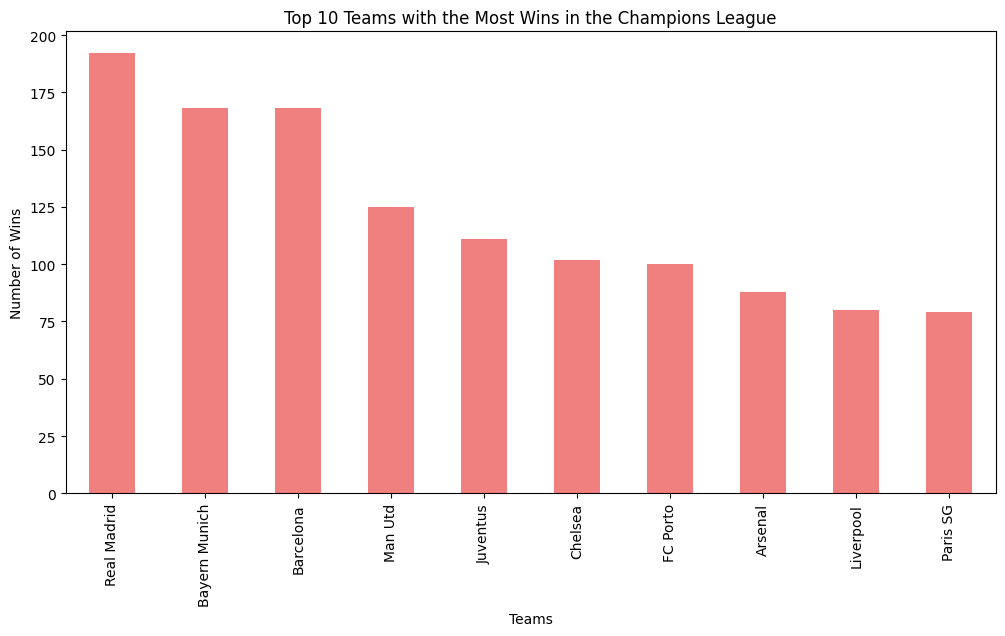

In [87]:
#get the number of wins a team has 

def get_wins(team):
    home_wins = football[football['Home Team'] == team]['Home Outcome'].value_counts().get('Win', 0)
    away_wins = football[football['Away Team'] == team]['Home Outcome'].value_counts().get('Loss', 0)
    return home_wins + away_wins

# get the wins for each team and plot the top 10
teams = football['Home Team'].unique()
team_wins = {team: get_wins(team) for team in teams}
team_wins = pd.Series(team_wins)
team_wins = team_wins.sort_values(ascending=False).head(10)
team_wins.plot(kind='bar', figsize=(12, 6), color='lightcoral', title='Top 10 Teams with the Most Wins in the Champions League', ylabel='Number of Wins', xlabel='Teams');

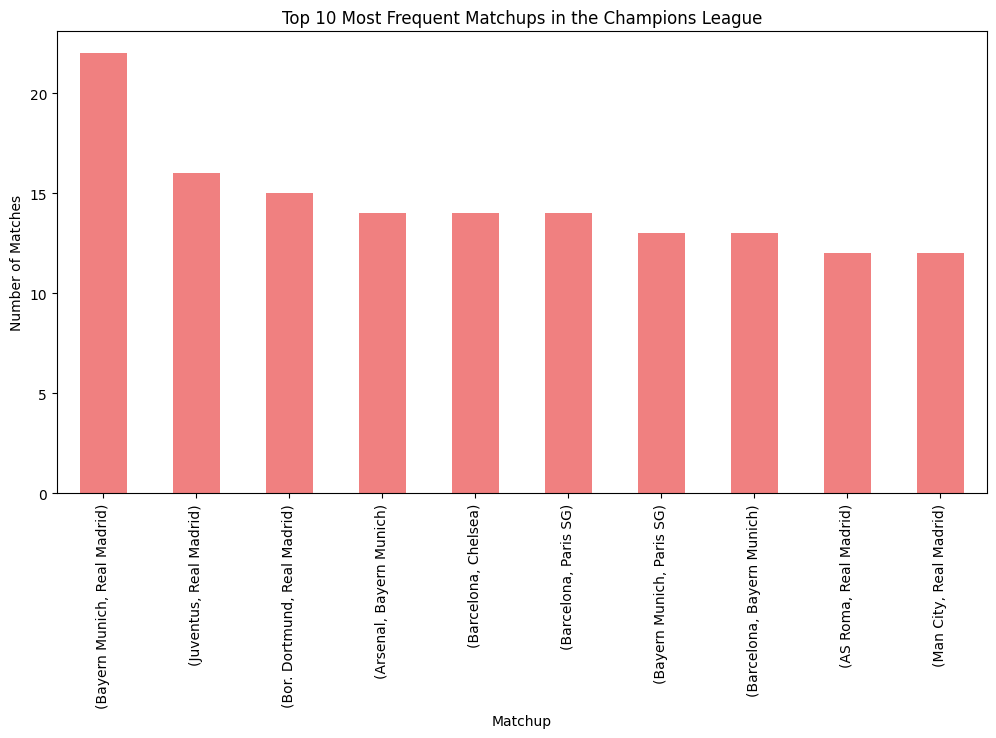

In [91]:
# Create a new column 'Teams' which is a sorted tuple of 'Home Team' and 'Away Team'
football['Teams'] = football.apply(lambda row: tuple(sorted([row['Home Team'], row['Away Team']])), axis=1)

# Group by the new 'Teams' column and count the matches
match_combinations = football.groupby('Teams').size().reset_index(name='Count')

# Sort by 'Count' and get the top 10
match_combinations = match_combinations.sort_values('Count', ascending=False).head(10)

match_combinations.plot(kind='bar', x='Teams', y='Count', figsize=(12, 6), color='lightcoral', title='Top 10 Most Frequent Matchups in the Champions League', legend=False, ylabel='Number of Matches', xlabel='Matchup');


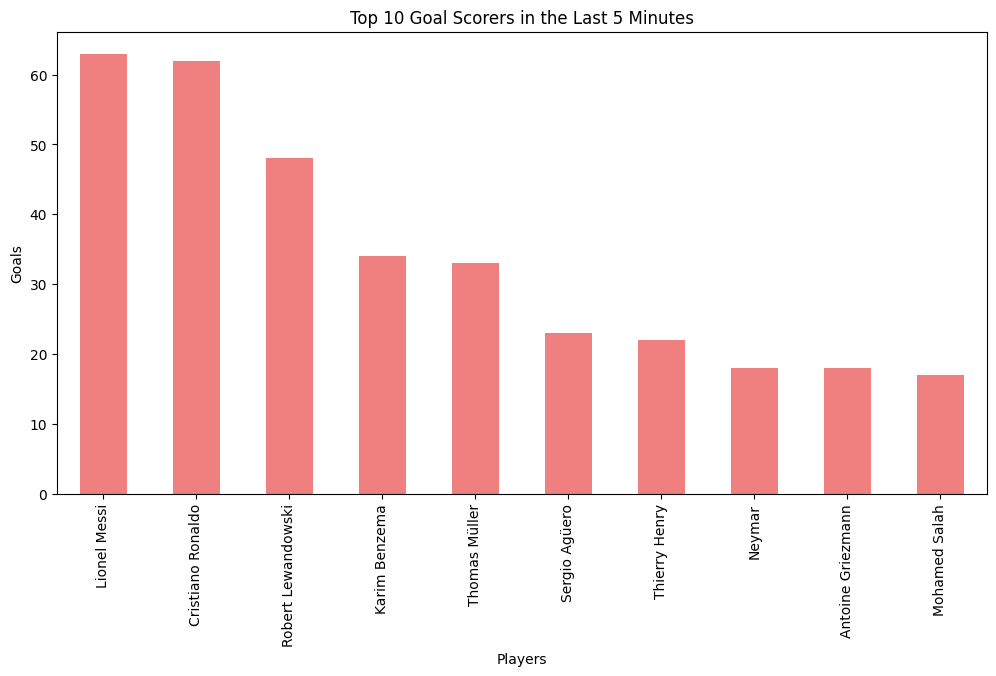

In [89]:
#calulate the top 10 scorers who score from the 85th minute. The minutes are in the column 'Scoresheet_Home' and 'Scoresheet_Away'
home_scorers = football['Scoresheet_Home'].explode().dropna()
home_scorers = home_scorers[home_scorers >= 85].index
away_scorers = football['Scoresheet_Away'].explode().dropna()
away_scorers = away_scorers[away_scorers >= 85].index
scorers_late = football['Scorer_Home'].explode().dropna().loc[home_scorers].value_counts()

scorers_late = scorers_late.add(football['Scorer_Away'].explode().dropna().loc[away_scorers].value_counts(), fill_value=0).astype(int)
scorers_late = scorers_late.sort_values(ascending=False).head(10)
scorers_late.plot(kind='bar', figsize=(12, 6), color='lightcoral', title='Top 10 Goal Scorers in the Last 5 Minutes', ylabel='Goals', xlabel='Players');

# Networkx

In [4]:
# 10 Season slice
sliced = football.iloc[2468:].copy().reset_index(drop=True)


G = nx.MultiGraph()

for i in range(len(sliced)):
    G.add_edge(sliced['Home Team'][i], sliced['Away Team'][i], time=sliced['Date'][i])

print(G)
sliced

MultiGraph with 88 nodes and 1244 edges


,Date,Home Team,Away Team,Result,Stage,Scoresheet_Home,Scorer_Home,Scoresheet_Away,Scorer_Away,Year,Home Outcome
0,2014-09-16,Olympiacos,Atlético Madrid,3:2,Group A,"[13, 31, 73]","['Arthur Masuaku', 'Ibrahim Afellay', 'Konstan...","[38, 86]","['Mario Mandžukić', 'Antoine Griezmann']",2014,Win
1,2014-09-16,Juventus,Malmö FF,2:0,Group A,"[59, 90]","['Carlos Tevez', 'Carlos Tevez']",[],[],2014,Win
2,2014-10-01,Atlético Madrid,Juventus,1:0,Group A,[74],['Arda Turan'],[],[],2014,Win
3,2014-10-01,Malmö FF,Olympiacos,2:0,Group A,"[42, 82]","['Markus Rosenberg', 'Markus Rosenberg']",[],[],2014,Win
4,2014-10-22,Olympiacos,Juventus,1:0,Group A,[36],['Pajtim Kasami'],[],[],2014,Win
...,...,...,...,...,...,...,...,...,...,...,...
1239,2024-04-30,Bayern Munich,Real Madrid,2:2,Semi Finals Leg 1,"[53, 57]","['Leroy Sané', 'Harry Kane']","[24, 83]","['Vinicius Junior', 'Vinicius Junior']",2024,Draw
1240,2024-05-01,Bor. Dortmund,Paris SG,1:0,Semi Finals Leg 1,[36],['Niclas Füllkrug'],[],[],2024,Win
1241,2024-05-07,Paris SG,Bor. Dortmund,0:1,Semi Finals Leg 2,[],[],[50],['Mats Hummels'],2024,Loss
1242,2024-05-08,Real Madrid,Bayern Munich,2:1,Semi Finals Leg 2,"[88, 91]","['Joselu', 'Joselu']",[68],['Alphonso Davies'],2024,Win


In [5]:
importlib.reload(tm)

degree = pd.Series(tm.temporal_degree(G)).sort_values(ascending=False)
betweenness = pd.Series(tm.temporal_betweenness(G)).sort_values(ascending=False)
closeness = pd.Series(tm.temporal_closeness(G)).sort_values(ascending=False)

# put the metrics in a dataframe
df_metrics = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'Closeness': closeness
})



,Degree,Betweenness,Closeness
Real Madrid,117,0.088534,6.599599e-10
Bayern Munich,107,0.070074,6.580956e-10
Man City,105,0.063308,6.580956e-10
Paris SG,95,0.047908,6.577567e-10
Barcelona,94,0.048994,6.577567e-10
Atlético Madrid,92,0.055161,6.570019e-10
Juventus,84,0.045873,6.570019e-10
Bor. Dortmund,77,0.039571,6.572222e-10
FC Porto,74,0.049964,6.575260e-10
Liverpool,71,0.050184,6.599599e-10


In [33]:
df_metrics['Closeness'].sort_values(ascending=False).head(10)

Ludogorets       6.599599e-10
Liverpool        6.599599e-10
Real Madrid      6.599599e-10
FC Basel         6.599599e-10
NK Maribor       6.598116e-10
FC Schalke 04    6.598116e-10
Sporting CP      6.598116e-10
Chelsea          6.598116e-10
Bayern Munich    6.580956e-10
AS Roma          6.580956e-10
Name: Closeness, dtype: float64

In [7]:
df_metrics.mean().sort_values(ascending=False)

Degree         2.827273e+01
Betweenness    1.073485e-02
Closeness      6.347567e-10
dtype: float64

In [27]:
r = tm.calculate_reachability_ratio(G, 'time')
reach = tm.reachability_latency(G, 'time', r)
reach

0.04861111111111112

# Plot Slice Graph

In [156]:
finals = football[football['Stage'] == 'Final'].copy()
finals['Date'] = finals['Date'].dt.year
finals = finals[finals['Year'] >= 2014]
finals = finals[['Date', 'Home Team', 'Away Team', 'Result', 'Home Outcome']].reset_index(drop=True)


t = nx.MultiGraph()
season_slice = football.iloc[3699:].copy().reset_index(drop=True)


for i in range(len(finals)):
    t.add_edge(finals['Home Team'].iloc[i], finals['Away Team'].iloc[i], time=finals['Date'].iloc[i])

print(t)


MultiGraph with 12 nodes and 11 edges


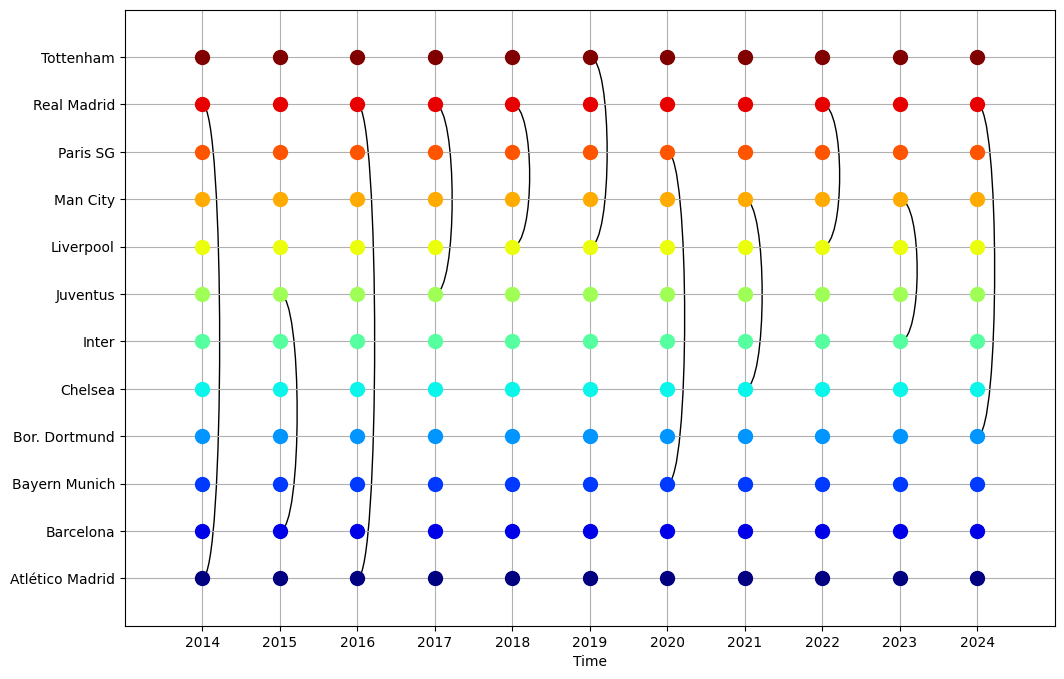

In [157]:
from matplotlib.patches import FancyArrowPatch

# Extract edges from the graph
temporal_edges = [(u, v, d['time']) for u, v, d in t.edges(data=True)]

# Extract unique nodes and time points
nodes = sorted(t.nodes())
time_points = sorted(set(edge[2]['time'] for edge in t.edges(data=True)))

# Create node positions
node_positions = {node: i for i, node in enumerate(nodes)}
time_positions = {time: i for i, time in enumerate(time_points)}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 8))

# Draw nodes
color_map = plt.cm.jet(np.linspace(0, 1, len(nodes)))
for node, node_idx in node_positions.items():
    for time, time_idx in time_positions.items():
        ax.plot(time_idx, node_idx, 'o', color=color_map[node_idx], markersize=10)

# Draw Bezier curves for edges
for edge in temporal_edges:
    node1, node2, time = edge
    x1, y1 = time_positions[time], node_positions[node1]
    x2, y2 = time_positions[time], node_positions[node2]

    
    # Create the curve bending to the right
    control_point_1 = (x1 + 0.3, y1)
    control_point_2 = (x2 + 0.3, y2)
    verts = [(x1, y1), control_point_1, control_point_2, (x2, y2)]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    
    path = Path(verts, codes)

    if t.is_directed():
        patch = FancyArrowPatch(path=path, color='black', lw=1, arrowstyle='-|>', mutation_scale=25)
    else:
        patch = PathPatch(path, facecolor='none', edgecolor='black', lw=1)
    ax.add_patch(patch)

# Customize plot
ax.set_xlim(-1, len(time_points))
ax.set_ylim(-1, len(nodes))
ax.set_xticks(range(len(time_points)))
ax.set_xticklabels([tp for tp in time_points])
# ax.set_xticklabels([tp.strftime('%Y-%m-%d') for tp in time_points])
ax.set_xlabel('Time')
ax.set_yticks(range(len(nodes)))
ax.set_yticklabels(nodes)
ax.grid(True)

plt.show()


# Pathpy (Not Fully Working)

In [17]:
pp.config['torch']['device'] = 'cpu'

seasons = football.copy()

min_d = seasons['Date'].min()
max_d = seasons['Date'].max()
num_days = (max_d - min_d).days
seasons.loc[:, 'day_number'] = (seasons['Date'] - min_d).dt.days + 1
seasons.loc[:, 'day_number'] = seasons.groupby('day_number').ngroup() + 1
# make an edge list
edges = []
for index, row in season_dates.iterrows():
    edges.append([row['Home Team'], row['Away Team'], row['day_number']])

edges

[['Feyenoord', 'Celtic', 1],
 ['Lazio', 'Atlético Madrid', 1],
 ['AC Milan', 'Newcastle', 1],
 ['Shakhtar D.', 'FC Porto', 1],
 ['Barcelona', 'Royal Antwerp', 1],
 ['Paris SG', 'Bor. Dortmund', 1],
 ['Man City', 'Red Star', 1],
 ['BSC Young Boys', 'RB Leipzig', 1],
 ['Galatasaray', 'FC Copenhagen', 2],
 ['SC Braga', 'SSC Napoli', 2],
 ['Real Madrid', 'Union Berlin', 2],
 ['Benfica', 'RB Salzburg', 2],
 ['Arsenal', 'PSV Eindhoven', 2],
 ['Real Sociedad', 'Inter', 2],
 ['Bayern Munich', 'Man Utd', 2],
 ['Sevilla FC', 'Lens', 2],
 ['PSV Eindhoven', 'Sevilla FC', 3],
 ['RB Salzburg', 'Real Sociedad', 3],
 ['SSC Napoli', 'Real Madrid', 3],
 ['Union Berlin', 'SC Braga', 3],
 ['Man Utd', 'Galatasaray', 3],
 ['Inter', 'Benfica', 3],
 ['FC Copenhagen', 'Bayern Munich', 3],
 ['Lens', 'Arsenal', 3],
 ['Atlético Madrid', 'Feyenoord', 4],
 ['Celtic', 'Lazio', 4],
 ['Royal Antwerp', 'Shakhtar D.', 4],
 ['Red Star', 'BSC Young Boys', 4],
 ['Newcastle', 'Paris SG', 4],
 ['RB Leipzig', 'Man City', 4],


In [19]:
t = pp.TemporalGraph.from_edge_list(edges)
style = {}
style['edge_color'] = colours

pp.plot(t, **style, node_label = [str(t.mapping.to_id(i)) for i in range(t.N)], delta=1000)
# print(t)

In [20]:
t = pp.TemporalGraph.from_edge_list(edges)
pp.algorithms.centrality.temporal_betweenness_centrality(t, delta=0)

100%|██████████| 29/29 [00:00<00:00, 9681.99it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [23]:
m = pp.MultiOrderModel.from_temporal_graph(t, delta=1, max_order=4)

pp.plot(m.layers[1], node_label=[v for v in m.layers[1].nodes])